# Time Evolving Block Decimation (TEBD)

Code and description borrowed from:
<cite>Glen Evenbly https://www.tensors.net</cite>

(Except for some tiny changes)

## Initialization of the infinite  MPS 
   
<div>
<img src="fig/mps_init.png" width="500"/>
</div>

The TEBD algorithm makes use of an infinite MPS, which describes a quantum state on an infinite 1D lattice. 

- we use an MPS with a 2-site unit cell, composed of `A` and `B` tensors, as this is the minimum unit cell compatible with TEBD. An MPS with a larger unit cell could be used if the periodicity of the quantum state that we are trying to describe is greater than 2 sites.

- for convenience we allow weights `sBA` and `sAB`, which are restricted to be diagonal matrices, to be positioned on links between the MPS tensors.

- by convention, the indices on MPS tensors are ordered left-centre-right.

- we call the local dimension as `d` (i.e. the dimension of the Hilbert space associated to each lattice site) and the MPS bond dimension as `𝛘` (although this is also called `m` in some of the literature.


In [1]:
  
import numpy as np
# initialize tensors
d = 2
chi = 10
A = np.random.rand(chi, d, chi)
B = np.random.rand(chi, d, chi)
sAB = np.ones(chi) / np.sqrt(chi)  # set trivial initial weights
sBA = np.ones(chi) / np.sqrt(chi)  # set trivial initial weights


## Contraction of an infinite MPS 

#### Fig. 2
<div>
<img src="fig/local_expectation.png" width="500"/>
</div>

Key in any tensor network algorithm is the evaluation of local expectation values from the network, like that of <Ψ|oAB|Ψ> shown in Fig.2(i). This is complicated in the infinite MPS, as we cannot directly contract an infinite network. In practice, as shown Fig. 2(ii), this difficulty can circumvented through the introduction of environment tensors σ and μ, which should be chosen to effectively account for the semi-infinite networks to the left and right of the region of interest. How can such tensors be chosen?

#### Fig. 3
<div>
<img src="fig/def_of_sigAB.png" width="500"/>
</div>

The answer is that the environment tensors σ and μ should be chosen as the dominant fixed points of the contractions shown in Fig.3(i-ii), which are known as the (left/right) MPS transfer operators. In practice, a simple method to find the environment tensors is to first initialize random tensors, and to then apply the transfer operators iteratively until they are converged to within a desired tolerance, as demonstrated below.

In [2]:
  
from numpy import linalg as LA
from ncon import ncon

""" Contract infinite MPS from the left for environment tensor sigBA """

sigBA = np.random.rand(chi, chi)  # initialize random starting point
tol = 1e-10  # set convergence tolerance

# define the tensor network
tensors = [np.diag(sBA), np.diag(sBA), A, A.conj(), np.diag(sAB),
           np.diag(sAB), B, B.conj()]
labels = [[1,2],[1,3],[2,4],[3,5,6],[4,5,7],[6,8],[7,9],[8,10,-1],[9,10,-2]]

for k in range(1000):
  sigBA_new = ncon([sigBA, *tensors], labels)  # contract transfer operator
  sigBA_new = sigBA_new / np.trace(sigBA_new)  # normalize
  if LA.norm(sigBA - sigBA_new) < tol:  # check convergence
    print('success!')
    break
  else:
    print('iter: %d, diff: %e' % (k, LA.norm(sigBA - sigBA_new)))
    sigBA = sigBA_new


iter: 0, diff: 5.097440e+00
iter: 1, diff: 4.073952e-03
iter: 2, diff: 4.968210e-05
iter: 3, diff: 7.433617e-07
iter: 4, diff: 7.552913e-09
iter: 5, diff: 1.418076e-10
success!


Notice that Fig.3(i-ii) is equivalent to an eigenvalue problem: the σ and μ tensors that we are trying to compute are the dominant eigenvectors of the left/right transfer operators (if interpreted as 𝛘^2-by-𝛘^2 matrices). The iterative method that we employed above is what is known as a power method. Although a valid approach, more efficient iterative methods are known (i.e. which require fewer iterations to converge), such as the Lanczos method. Fortunately we do not have to write our own implementation of the Lanczos method; instead we can employ a pre-packaged ARPACK version via the `eigs` function, as demonstrated below.

In [3]:
  
def left_contract_MPS(sigBA, sBA, A, sAB, B):
  """ Contract an infinite 2-site unit cell from the left for the environment
  density matrices sigBA (B-A link) and sigAB (A-B link)"""

  # initialize the starting vector
  chiBA = A.shape[0]
  if sigBA.shape[0] == chiBA:
    v0 = sigBA.reshape(np.prod(sigBA.shape))
  else:
    v0 = (np.eye(chiBA) / chiBA).reshape(chiBA**2)

  # define network for transfer operator contract
  tensors = [np.diag(sBA), np.diag(sBA), A, A.conj(), np.diag(sAB),
             np.diag(sAB), B, B.conj()]
  labels = [[1, 2], [1, 3], [2, 4], [3, 5, 6], [4, 5, 7], [6, 8], [7, 9],
            [8, 10, -1], [9, 10, -2]]

  # define function for boundary contraction and pass to eigs
  def left_iter(sigBA):
    return ncon([sigBA.reshape([chiBA, chiBA]), *tensors],
                labels).reshape([chiBA**2, 1])
  Dtemp, sigBA = eigs(LinearOperator((chiBA**2, chiBA**2), matvec=left_iter),
                      k=1, which='LM', v0=v0, tol=1e-10)

  # normalize the environment density matrix sigBA
  if np.isrealobj(A):
    sigBA = np.real(sigBA)
  sigBA = sigBA.reshape(chiBA, chiBA)
  sigBA = 0.5 * (sigBA + np.conj(sigBA.T))
  sigBA = sigBA / np.trace(sigBA)

  # compute density matric sigAB for A-B link
  sigAB = ncon([sigBA, np.diag(sBA), np.diag(sBA), A, np.conj(A)],
               [[1, 2], [1, 3], [2, 4], [3, 5, -1], [4, 5, -2]])
  sigAB = sigAB / np.trace(sigAB)

  return sigBA, sigAB


def right_contract_MPS(muAB, sBA, A, sAB, B):
  """ Contract an infinite 2-site unit cell from the right for the environment
  density matrices muAB (A-B link) and muBA (B-A link)"""

  # initialize the starting vector
  chiAB = A.shape[2]
  if muAB.shape[0] == chiAB:
    v0 = muAB.reshape(np.prod(muAB.shape))
  else:
    v0 = (np.eye(chiAB) / chiAB).reshape(chiAB**2)

  # define network for transfer operator contract
  tensors = [np.diag(sAB), np.diag(sAB), A, A.conj(), np.diag(sBA),
             np.diag(sBA), B, B.conj()]
  labels = [[1, 2], [3, 1], [5, 2], [6, 4, 3], [7, 4, 5], [8, 6], [10, 7],
            [-1, 9, 8], [-2, 9, 10]]

  # define function for boundary contraction and pass to eigs
  def right_iter(muAB):
    return ncon([muAB.reshape([chiAB, chiAB]), *tensors],
                labels).reshape([chiAB**2, 1])
  Dtemp, muAB = eigs(LinearOperator((chiAB**2, chiAB**2), matvec=right_iter),
                     k=1, which='LM', v0=v0, tol=1e-10)

  # normalize the environment density matrix muAB
  if np.isrealobj(A):
    muAB = np.real(muAB)
  muAB = muAB.reshape(chiAB, chiAB)
  muAB = 0.5 * (muAB + np.conj(muAB.T))
  muAB = muAB / np.trace(muAB)

  # compute density matrix muBA for B-A link
  muBA = ncon([muAB, np.diag(sAB), np.diag(sAB), A, A.conj()],
              [[1, 2], [3, 1], [5, 2], [-1, 4, 3], [-2, 4, 5]])
  muBA = muBA / np.trace(muBA)

  return muAB, muBA


## Canonical Form

#### Fig. 4

<div>
<img src="fig/canonical_form.png" width="500"/>
</div>

Next we describe how to bring the MPS into canonical form via an appropriate gauge transformation. As discussed in tutorials 3 and 4, use of the canonical form simplifies network contractions and also allow for optimal truncations of tensors within a network. Use of the canonical for is thus a key component of the TEBD algorithm.

- we shall begin by orthogonalizing only the B-A links of the MPS, noting that the A-B links can afterwards be handled in an identical manner.

- we shall use the `direct orthogonalization` approach discussed in tutorial 3, where the change of gauge is made via X and Y matrices (and their inverses) as shown in Fig.4(i).

- Fig.4(ii) represents the contraction of MPS with itself across a B-A link. The X and Y gauge change matrices are chosen such that the environment tensors σBA and μBA are be proportional to the identity after the change of gauge as shown.

- we find the gauge change matrices via the eigen-decomposition of the environment tensors σBA and μBA as shown in the code below.  


In [4]:
  
def orthog_MPS(sigBA, muBA, B, sBA, A, dtol=1e-12):
  """ set the MPS gauge across B-A link to the canonical form """

  # diagonalize left environment
  dtemp, utemp = LA.eigh(sigBA)
  chitemp = sum(dtemp > dtol)
  DL = dtemp[range(-1, -chitemp - 1, -1)]
  UL = utemp[:, range(-1, -chitemp - 1, -1)]

  # diagonalize right environment
  dtemp, utemp = LA.eigh(muBA)
  chitemp = sum(dtemp > dtol)
  DR = dtemp[range(-1, -chitemp - 1, -1)]
  UR = utemp[:, range(-1, -chitemp - 1, -1)]

  # compute new weights for B-A link
  weighted_mat = (np.diag(np.sqrt(DL)) @ UL.T @ np.diag(sBA)
                  @ UR @ np.diag(np.sqrt(DR)))
  UBA, stemp, VhBA = LA.svd(weighted_mat, full_matrices=False)
  sBA = stemp / LA.norm(stemp)

  # build x,y gauge change matrices, implement gauge change on A and B
  x = np.conj(UL) @ np.diag(1 / np.sqrt(DL)) @ UBA
  y = np.conj(UR) @ np.diag(1 / np.sqrt(DR)) @ VhBA.T
  A = ncon([y, A], [[1, -1], [1, -2, -3]])
  B = ncon([B, x], [[-1, -2, 2], [2, -3]])

  return B, sBA, A


## Time Evolution

#### Fig. 5

<div>
<img src="fig/trotter.png" width="500"/>
</div>


We now describe the most important part of the TEBD algorithm: applying the time-evolution gates to the MPS. For simplicity we shall focus on the case of an imaginary-time evolution, although the same approach is used for a real-time evolution. Starting from an initial MPS |Ψ> we wish to construct the MPS for the time evolved state exp(-tH)|Ψ>. As shown in Fig.5, the exponential of a local Hamiltonian H can be approximated as a product of local gates exp(-𝜏h), where 𝜏 is a small time-step, via a Suzuki-Trotter decomposition. Presented below is an example of exponentiating a local Hamiltonian.

In [5]:
  
from scipy.linalg import expm

# define a Hamiltonian (here the quantum XX model)
sX = np.array([[0, 1], [1, 0]])
sY = np.array([[0, -1j], [1j, 0]])
hamAB = (np.real(np.kron(sX, sX) + np.kron(sY, sY))).reshape(2, 2, 2, 2)
hamBA = hamAB

# exponentiate Hamiltonian
tau = 0.1  # set time-step
evotype = 'imag'  # set imaginary time evolution
if evotype == "real":
  gateAB = expm(1j * tau * hamAB.reshape(d**2, d**2)).reshape(d, d, d, d)
  gateBA = expm(1j * tau * hamBA.reshape(d**2, d**2)).reshape(d, d, d, d)
elif evotype == "imag":
  gateAB = expm(-tau * hamAB.reshape(d**2, d**2)).reshape(d, d, d, d)
  gateBA = expm(-tau * hamBA.reshape(d**2, d**2)).reshape(d, d, d, d)


#### Fig.6

<div>
<img src="fig/gate.png" width="500"/>
</div>

As shown in Fig.6, a key step in TEBD is the contraction of a gate into a pair of MPS tensors, followed by splitting back into a new pair of MPS tensors.

- the adjacent link weights sBA should be absorbed into the composite tensor before truncation. This ensures that the truncation will minimize the global error as discussed in tutorial 3. 

- the splitting of the composite tensor is accomplished via a truncated SVD as discussed extensively in tutorial 2.

- after the splitting, the adjacent link weights sBA should be again factored out, which can be accomplished by applying their inverses.

- some care should be taken to ensure that link weights sBA are not too small, which can otherwise lead to numerical instability due to finite precision arithmetic.


In [6]:
  
def apply_gate_MPS(gateAB, A, sAB, B, sBA, chi, stol=1e-7):
  """ apply a gate to an MPS across and a A-B link. Truncate the MPS back to
  some desired dimension chi"""

  # ensure singular values are above tolerance threshold
  sBA_trim = sBA * (sBA > stol) + stol * (sBA < stol)

  # contract gate into the MPS, then deompose composite tensor with SVD
  d = A.shape[1]
  chiBA = sBA_trim.shape[0]
  tensors = [np.diag(sBA_trim), A, np.diag(sAB), B, np.diag(sBA_trim), gateAB]
  connects = [[-1, 1], [1, 5, 2], [2, 4], [4, 6, 3], [3, -4], [-2, -3, 5, 6]]
  nshape = [d * chiBA, d * chiBA]
  utemp, stemp, vhtemp = LA.svd(ncon(tensors, connects).reshape(nshape),
                                full_matrices=False)

  # truncate to reduced dimension
  chitemp = min(chi, len(stemp))
  utemp = utemp[:, range(chitemp)].reshape(sBA_trim.shape[0], d * chitemp)
  vhtemp = vhtemp[range(chitemp), :].reshape(chitemp * d, chiBA)

  # remove environment weights to form new MPS tensors A and B
  A = (np.diag(1 / sBA_trim) @ utemp).reshape(sBA_trim.shape[0], d, chitemp)
  B = (vhtemp @ np.diag(1 / sBA_trim)).reshape(chitemp, d, chiBA)

  # discarded weights (this is added to the original version)
  dw = sum(stemp[chitemp:])

  # new weights
  sAB = stemp[range(chitemp)] / LA.norm(stemp[range(chitemp)])

  return A, sAB, B, dw


## Putting everything together

The TEBD algorithm begins with a randomly initialized MPS and then iterates many of the steps described above . Specifically, each iteration involves:

- solve for left/right environment tensors (using a Lanzcos method).

- bring MPS into canonical form.

- apply time-evolution gates across A-B links, and then across B-A links.

​

Notes:

- solving for the left/right environment tensors and bringing the MPS into canonical form is computationally expensive to do every iteration. In practice it is more efficient to perform multiple steps of applying the time evolution gates between solving for the left/right environment tensors.

- it is often most efficient to start with a larger time-step 𝜏 for the initial iterations, and then reduce to smaller time-steps at later iterations (to improve the final accuracy).  


In [7]:
  
# doTEBD.py
# ---------------------------------------------------------------------
# Implementation of time evolution (real or imaginary) for MPS with 2-site unit
# cell (A-B), based on TEBD algorithm.
#
# by Glen Evenbly (c) for www.tensors.net, (v1.2) - last modified 6/2019

import numpy as np
from numpy import linalg as LA
from scipy.linalg import expm
from scipy.sparse.linalg import LinearOperator, eigs
from ncon import ncon
from typing import Optional


def doTEBD(hamAB: np.ndarray,
           hamBA: np.ndarray,
           A: np.ndarray,
           B: np.ndarray,
           sAB: np.ndarray,
           sBA: np.ndarray,
           chi: int,
           tau: float,
           evotype: Optional[str] = 'imag',
           numiter: Optional[int] = 1000,
           midsteps: Optional[int] = 10,
           E0: Optional[float] = 0.0):
  """
  Implementation of time evolution (real or imaginary) for MPS with 2-site unit
  cell (A-B), based on TEBD algorithm.
  Args:
    hamAB: nearest neighbor Hamiltonian coupling for A-B sites.
    hamBA: nearest neighbor Hamiltonian coupling for B-A sites.
    A: MPS tensor for A-sites of lattice.
    B: MPS tensor for B-sites of lattice.
    sAB: vector of weights for A-B links.
    sBA: vector of weights for B-A links.
    chi: maximum bond dimension of MPS.
    tau: time-step of evolution.
    evotype: set real (evotype='real') or imaginary (evotype='imag') evolution.
    numiter: number of time-step iterations to take.
    midsteps: number of time-steps between re-orthogonalization of the MPS.
    E0: specify the ground energy (if known).
  Returns:
    np.ndarray: MPS tensor for A-sites;
    np.ndarray: MPS tensor for B-sites;
    np.ndarray: vector sAB of weights for A-B links.
    np.ndarray: vector sBA of weights for B-A links.
    np.ndarray: two-site reduced density matrix rhoAB for A-B sites
    np.ndarray: two-site reduced density matrix rhoAB for B-A sites
  """

  # exponentiate Hamiltonian
  d = A.shape[1]
  if evotype == "real":
    gateAB = expm(1j * tau * hamAB.reshape(d**2, d**2)).reshape(d, d, d, d)
    gateBA = expm(1j * tau * hamBA.reshape(d**2, d**2)).reshape(d, d, d, d)
  elif evotype == "imag":
    gateAB = expm(-tau * hamAB.reshape(d**2, d**2)).reshape(d, d, d, d)
    gateBA = expm(-tau * hamBA.reshape(d**2, d**2)).reshape(d, d, d, d)

  # initialize environment matrices
  sigBA = np.eye(A.shape[0]) / A.shape[0]
  muAB = np.eye(A.shape[2]) / A.shape[2]

  for k in range(numiter + 1):
    if np.mod(k, midsteps) == 0 or (k == numiter):
      """ Bring MPS to normal form """

      # contract MPS from left and right
      sigBA, sigAB = left_contract_MPS(sigBA, sBA, A, sAB, B)
      muAB, muBA = right_contract_MPS(muAB, sBA, A, sAB, B)

      # orthogonalise A-B and B-A links
      B, sBA, A = orthog_MPS(sigBA, muBA, B, sBA, A)
      A, sAB, B = orthog_MPS(sigAB, muAB, A, sAB, B)

      # normalize the MPS tensors
      A_norm = np.sqrt(ncon([np.diag(sBA**2), A, np.conj(A), np.diag(sAB**2)],
                            [[1, 3], [1, 4, 2], [3, 4, 5], [2, 5]]))
      A = A / A_norm
      B_norm = np.sqrt(ncon([np.diag(sAB**2), B, np.conj(B), np.diag(sBA**2)],
                            [[1, 3], [1, 4, 2], [3, 4, 5], [2, 5]]))
      B = B / B_norm

      """ Compute energy and display """

      # compute 2-site local reduced density matrices
      rhoAB, rhoBA = loc_density_MPS(A, sAB, B, sBA)

      # evaluate the energy
      energyAB = ncon([hamAB, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]])
      energyBA = ncon([hamBA, rhoBA], [[1, 2, 3, 4], [1, 2, 3, 4]])
      energy = 0.5 * (energyAB + energyBA)

      chitemp = min(A.shape[0], B.shape[0])
      enDiff = energy - E0
      if evotype == 'imag':
        print('iteration: {k} of {numiter}, chi: {chitemp}, t-step: {tau:.4}, energy: {energy:.4}, energy error: {enDiff:.2e}'
              .format(k=k, numiter=numiter, chitemp=chitemp, tau=tau, energy=energy, enDiff=enDiff))

    """ Do evolution of MPS through one time-step """
    if k < numiter:
      # apply gate to A-B link
      A, sAB, B, dwAB = apply_gate_MPS(gateAB, A, sAB, B, sBA, chi)

      # apply gate to B-A link
      B, sBA, A, dwBA = apply_gate_MPS(gateBA, B, sBA, A, sAB, chi)

  rhoAB, rhoBA = loc_density_MPS(A, sAB, B, sBA)
  return A, B, sAB, sBA, rhoAB, rhoBA, max(dwAB, dwBA)


def loc_density_MPS(A, sAB, B, sBA):
  """ Compute the local reduced density matrices from an MPS (assumend to be
  in canonical form)."""

  # recast singular weights into a matrix
  mAB = np.diag(sAB)
  mBA = np.diag(sBA)

  # contract MPS for local reduced density matrix (A-B)
  tensors = [np.diag(sBA**2), A, A.conj(), mAB, mAB, B, B.conj(),
             np.diag(sBA**2)]
  connects = [[3, 4], [3, -3, 1], [4, -1, 2], [1, 7], [2, 8], [7, -4, 5],
              [8, -2, 6], [5, 6]]
  rhoAB = ncon(tensors, connects)

  # contract MPS for local reduced density matrix (B-A)
  tensors = [np.diag(sAB**2), B, B.conj(), mBA, mBA, A, A.conj(),
             np.diag(sAB**2)]
  connects = [[3, 4], [3, -3, 1], [4, -1, 2], [1, 7], [2, 8], [7, -4, 5],
              [8, -2, 6], [5, 6]]
  rhoBA = ncon(tensors, connects)

  return rhoAB, rhoBA




## Initialization Script --- Imaginary time evolution with TEBD:

In [8]:
  
"""
mainTEBD.py
---------------------------------------------------------------------
Script file for initializing the Hamiltonian and MPS tensors before passing to
the TEBD routine.

by Glen Evenbly (c) for www.tensors.net, (v1.2) - last modified 06/2020
"""

# preamble
import numpy as np
#from doTEBD import doTEBD
from ncon import ncon

""" Example 1: XX model """

# set bond dimensions and simulation options
chi0 = 4
chi = 16  # bond dimension
tau = 0.1  # timestep

numiter = 500  # number of timesteps
evotype = "imag"  # real or imaginary time evolution
E0 = -4 / np.pi  # specify exact ground energy (if known)
midsteps = int(1 / tau)  # timesteps between MPS re-orthogonalization

# define Hamiltonian (quantum XX model)
sX = np.array([[0, 1], [1, 0]])
sY = np.array([[0, -1j], [1j, 0]])
sZ = np.array([[1, 0], [0, -1]])
hamAB = (np.real(np.kron(sX, sX) + np.kron(sY, sY))).reshape(2, 2, 2, 2)
hamBA = (np.real(np.kron(sX, sX) + np.kron(sY, sY))).reshape(2, 2, 2, 2)

# initialize tensors
d = hamAB.shape[0]
sAB = np.ones(chi0) / np.sqrt(chi0)
sBA = np.ones(chi0) / np.sqrt(chi0)
A = np.random.rand(chi0, d, chi0)
B = np.random.rand(chi0, d, chi0)

""" Imaginary time evolution with TEBD """
# run TEBD routine
A, B, sAB, sBA, rhoAB, rhoBA, discarded_weight = doTEBD(hamAB, hamBA, A, B, sAB, sBA, chi,
    tau, evotype=evotype, numiter=numiter, midsteps=midsteps, E0=E0)

# uncomment the following in order to get more accurate results!

"""
# continute running TEBD routine with reduced timestep
tau = 0.01
numiter = 2000
midsteps = 100
A, B, sAB, sBA, rhoAB, rhoBA = doTEBD(hamAB, hamBA, A, B, sAB, sBA, chi,
    tau, evotype=evotype, numiter=numiter, midsteps=midsteps, E0=E0)

# continute running TEBD routine with reduced timestep and increased bond dim
chi = 32
tau = 0.001
numiter = 20000
midsteps = 1000
A, B, sAB, sBA, rhoAB, rhoBA = doTEBD(hamAB, hamBA, A, B, sAB, sBA, chi,
    tau, evotype=evotype, numiter=numiter, midsteps=midsteps, E0=E0)
"""

# compare with exact results
energyMPS = np.real(0.5 * ncon([hamAB, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]]) +
                    0.5 * ncon([hamBA, rhoBA], [[1, 2, 3, 4], [1, 2, 3, 4]]))
enErr = abs(energyMPS - E0)
print('Final results => Bond dim: %d, Energy: %f, Energy Error: %e' %
      (chi, energyMPS, enErr))


iteration: 0 of 500, chi: 4, t-step: 0.1, energy: 0.9224, energy error: 2.20e+00
iteration: 10 of 500, chi: 16, t-step: 0.1, energy: -1.251, energy error: 2.20e-02
iteration: 20 of 500, chi: 16, t-step: 0.1, energy: -1.263, energy error: 1.06e-02
iteration: 30 of 500, chi: 16, t-step: 0.1, energy: -1.264, energy error: 9.32e-03
iteration: 40 of 500, chi: 16, t-step: 0.1, energy: -1.264, energy error: 8.92e-03
iteration: 50 of 500, chi: 16, t-step: 0.1, energy: -1.264, energy error: 8.76e-03
iteration: 60 of 500, chi: 16, t-step: 0.1, energy: -1.265, energy error: 8.69e-03
iteration: 70 of 500, chi: 16, t-step: 0.1, energy: -1.265, energy error: 8.65e-03
iteration: 80 of 500, chi: 16, t-step: 0.1, energy: -1.265, energy error: 8.63e-03
iteration: 90 of 500, chi: 16, t-step: 0.1, energy: -1.265, energy error: 8.62e-03
iteration: 100 of 500, chi: 16, t-step: 0.1, energy: -1.265, energy error: 8.62e-03
iteration: 110 of 500, chi: 16, t-step: 0.1, energy: -1.265, energy error: 8.61e-03
iter

### Real time evolution with TEBD

- In this example we are going to make a real time evolution of an initial state under the nearest neighbour 1d Heisenberg Hamiltonian.
- The initial state is the neel ordered product state
- we will collect the discarded weight as an indication of the quality of the evolution (cf the plot in the next cell)

In [9]:
# preamble
import numpy as np
#from doTEBD import doTEBD
from ncon import ncon

""" Example 2: time evolution of the Heisenberg model """

# set bond dimensions and simulation options
chi_max = 32  # bond dimension
tau = 0.05  # timestep

T = 4 # some slightly too long time to evolve (so we see the unphysical behaviour)
numiter = int(T / tau) # number of timesteps
evotype = "real"  # real or imaginary time evolution
E0 = -4 / np.pi  # specify exact ground energy (if known)
midsteps = 1 #int(1 / tau)  # timesteps between MPS re-orthogonalization

# define Hamiltonian (quantum Heisenberg model)
identity = np.eye(2)
sX = np.array([[0, 1], [1, 0]])
sY = np.array([[0, -1j], [1j, 0]])
sZ = np.array([[1, 0], [0, -1]])
hamAB = (np.real(np.kron(sX, sX) + np.kron(sY, sY) + np.kron(sZ, sZ))).reshape(2, 2, 2, 2)
hamBA = (np.real(np.kron(sX, sX) + np.kron(sY, sY) + np.kron(sZ, sZ))).reshape(2, 2, 2, 2)
sZid = np.kron(sZ, identity).reshape(2, 2, 2, 2)
idsZ = np.kron(identity, sZ).reshape(2, 2, 2, 2)

# initialize tensors
d = hamAB.shape[0]
chi_init = 3
sAB = np.ones(chi_init) / np.sqrt(chi_init)
sBA = np.ones(chi_init) / np.sqrt(chi_init)
A = 1e-5 * np.random.rand(chi_init, d, chi_init) #np.zeros([chi_init, d, chi_init])
B = 1e-5 * np.random.rand(chi_init, d, chi_init) #np.zeros([chi_init, d, chi_init])
# initialize antiferromagnetically ordered 
A[0, 0, 0] = 1
B[0, 1, 0] = 1

sZA_list = []
sZB_list = []
dw_list = []

""" Preprocessing for expectation values """

# initialize environment matrices
sigBA = np.eye(A.shape[0]) / A.shape[0]
muAB = np.eye(A.shape[2]) / A.shape[2]

# contract MPS from left and right
sigBA, sigAB = left_contract_MPS(sigBA, sBA, A, sAB, B)
muAB, muBA = right_contract_MPS(muAB, sBA, A, sAB, B)

# orthogonalise A-B and B-A links
B, sBA, A = orthog_MPS(sigBA, muBA, B, sBA, A)
A, sAB, B = orthog_MPS(sigAB, muAB, A, sAB, B)

# normalize the MPS tensors
A_norm = np.sqrt(ncon([np.diag(sBA**2), A, np.conj(A), np.diag(sAB**2)],
                            [[1, 3], [1, 4, 2], [3, 4, 5], [2, 5]]))
A = A / A_norm
B_norm = np.sqrt(ncon([np.diag(sAB**2), B, np.conj(B), np.diag(sBA**2)],
                            [[1, 3], [1, 4, 2], [3, 4, 5], [2, 5]]))
B = B / B_norm

# compute 2-site local reduced density matrices
rhoAB, rhoBA = loc_density_MPS(A, sAB, B, sBA)

# measure local sZ expectation values
sZA = ncon([sZid, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]])
sZB = ncon([idsZ, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]])

print('sZA = {sza}\tsZB = {szb}'.format(sza=sZA, szb=sZB))

sZA_list.append(sZA)
sZB_list.append(sZB)
dw_list.append(0)

""" Real time evolution with TEBD """
for k in range(numiter):
    # run TEBD routine
    A, B, sAB, sBA, rhoAB, rhoBA, dw = doTEBD(hamAB, hamBA, A, B, sAB, sBA, chi_max,
                                          tau, evotype=evotype, numiter=1, midsteps=midsteps, E0=E0)
    # measure local sZ expectation values
    sZA = ncon([sZid, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]])
    sZB = ncon([idsZ, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]])
    
    print('step {k} of {numiter}, chi = {chi}, sZA = {sza:.4}, sZB = {szb:.4}, discarded weight = {dw:.2e}'.format(
        k=k, numiter=numiter, chi=A.shape[0], sza=np.real(sZA), szb=np.real(sZB), dw=dw))

    sZA_list.append(sZA)
    sZB_list.append(sZB)
    dw_list.append(dw)



sZA = 0.9999999998233882	sZB = -0.999999999999867
step 0 of 80, chi = 4, sZA = 0.9605, sZB = -0.9605, discarded weight = 0.00e+00
step 1 of 80, chi = 16, sZA = 0.8483, sZB = -0.8483, discarded weight = 0.00e+00
step 2 of 80, chi = 32, sZA = 0.6805, sZB = -0.6805, discarded weight = 7.15e-09
step 3 of 80, chi = 32, sZA = 0.4819, sZB = -0.4819, discarded weight = 1.58e-06
step 4 of 80, chi = 32, sZA = 0.2795, sZB = -0.2795, discarded weight = 6.63e-06
step 5 of 80, chi = 32, sZA = 0.09814, sZB = -0.09814, discarded weight = 9.71e-06
step 6 of 80, chi = 32, sZA = -0.04397, sZB = 0.04397, discarded weight = 1.03e-05
step 7 of 80, chi = 32, sZA = -0.1373, sZB = 0.1373, discarded weight = 3.94e-06
step 8 of 80, chi = 32, sZA = -0.1811, sZB = 0.1811, discarded weight = 1.59e-06
step 9 of 80, chi = 32, sZA = -0.182, sZB = 0.182, discarded weight = 2.58e-06
step 10 of 80, chi = 32, sZA = -0.1517, sZB = 0.1517, discarded weight = 7.03e-06
step 11 of 80, chi = 32, sZA = -0.1034, sZB = 0.1034, dis

/Users/alex/Library/Caches/pypoetry/virtualenvs/tnseminar-1VvsSiVU-py3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/alex/Library/Caches/pypoetry/virtualenvs/tnseminar-1VvsSiVU-py3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


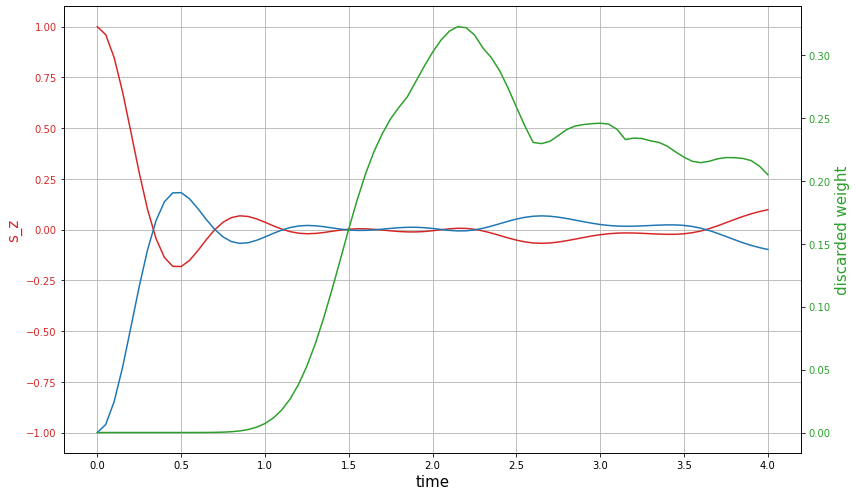

In [10]:
import matplotlib
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Data for plotting
t = np.arange(0.0, T+tau, tau)

fig, ax1 = plt.subplots(figsize=(12, 7))

color = 'tab:red'
color2 = 'tab:blue'
ax1.set_xlabel('time')
ax1.set_ylabel('s_z', color=color)
ax1.plot(t, sZA_list, color=color)
ax1.plot(t, sZB_list, color=color2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('discarded weight', color=color)  # we already handled the x-label with ax1
ax2.plot(t, dw_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()